# Lab 10:

In [1]:
import os
import numpy as np
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

In [12]:
def make_spectrogram(samples, sample_rate, filepath):
    freq, t, spec = signal.spectrogram(samples, sample_rate, window=('hann'))
    spec = np.log10(spec + 1)
    plt.pcolormesh(t, freq, spec, shading='gouraud', vmin=spec.min(), vmax=spec.max())
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.savefig(filepath)

    return freq, t, spec

In [13]:
def get_max_min(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    frequencies = librosa.fft_frequencies(sr=sr)
    mean_spec = np.mean(D, axis=1)

    idx_min = np.argmax(mean_spec > -80)
    idx_max = len(mean_spec) - np.argmax(mean_spec[::-1] > -80) - 1

    min_freq = frequencies[idx_min]
    max_freq = frequencies[idx_max]

    return max_freq, min_freq

In [14]:
def get_max_tembr(filepath):
    data, sample_rate = librosa.load(filepath)
    chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate)
    f0 = librosa.piptrack(y=data, sr=sample_rate, S=chroma)[0]
    max_f0 = np.argmax(f0)
    return max_f0

In [15]:
def get_peaks(freq, t, spec):
    delta_t = int(0.1 * len(t))
    delta_freq = int(50 / (freq[1] - freq[0]))
    filtered = maximum_filter(spec, size=(delta_freq, delta_t))

    peaks_mask = (spec == filtered)
    peak_values = spec[peaks_mask]
    peak_frequencies = freq[peaks_mask.any(axis=1)]

    top_indices = np.argsort(peak_values)[-3:]
    top_frequencies = peak_frequencies[top_indices]

    return list(top_frequencies)

# Main

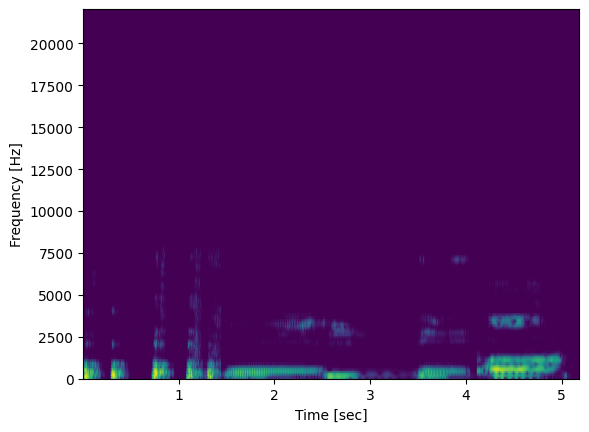

In [10]:
def main():
    input_path = 'input'
    output_path = 'output'

    voices = ['letter_a', 'letter_i', 'bark']
    voice_paths = [
        (voice, os.path.join(input_path, f'{voice}.wav'))
        for voice in voices
    ]
    with open(os.path.join(output_path, 'res.txt'), 'w') as res_file:
        for voice, voice_path in voice_paths:
            rate, samples = wavfile.read(voice_path)
            freq, t, spec = make_spectrogram(samples, rate, os.path.join(output_path, f'{voice}.png'))
            max_freq, min_freq = get_max_min(voice_path)

            res_file.write(f'{voice}:\n')
            res_file.write(f'\tMax Frequency: {max_freq}\n')
            res_file.write(f'\tMin Frequency: {min_freq}\n')
            res_file.write(f"\tMost timbral colored basic tone: {get_max_tembr(voice_path)}. "
                            "This is the frequency for which the largest number of overtones can be traced\n")
            if 'letter' in voice:
                res_file.write(f"\tthree strongest formants for the sounds : {get_peaks(freq, t, spec)}. "
                                "These are the frequencies with the highest energy in the region\n")
                
if __name__ == "__main__":
    main()
